# Load SEED Dataset

### Load RAW EEG

In [1]:
from dataset_processing.seed_dataset_loader import SeedDatasetLoader

sampling_frequency = 200  # 200 Hz

_loader = SeedDatasetLoader(fs=sampling_frequency)

Going through files:   0%|          | 0/47 [00:00<?, ?it/s]

In [2]:
labels = _loader.get_labels()
labels

array([[ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1]],
      dtype=int16)

In [3]:
channel_order = _loader.get_channel_order()
channel_order

{0: 'FP1',
 1: 'FPZ',
 2: 'FP2',
 3: 'AF3',
 4: 'AF4',
 5: 'F7',
 6: 'F5',
 7: 'F3',
 8: 'F1',
 9: 'FZ',
 10: 'F2',
 11: 'F4',
 12: 'F6',
 13: 'F8',
 14: 'FT7',
 15: 'FC5',
 16: 'FC3',
 17: 'FC1',
 18: 'FCZ',
 19: 'FC2',
 20: 'FC4',
 21: 'FC6',
 22: 'FT8',
 23: 'T7',
 24: 'C5',
 25: 'C3',
 26: 'C1',
 27: 'CZ',
 28: 'C2',
 29: 'C4',
 30: 'C6',
 31: 'T8',
 32: 'TP7',
 33: 'CP5',
 34: 'CP3',
 35: 'CP1',
 36: 'CPZ',
 37: 'CP2',
 38: 'CP4',
 39: 'CP6',
 40: 'TP8',
 41: 'P7',
 42: 'P5',
 43: 'P3',
 44: 'P1',
 45: 'PZ',
 46: 'P2',
 47: 'P4',
 48: 'P6',
 49: 'P8',
 50: 'PO7',
 51: 'PO5',
 52: 'PO3',
 53: 'POZ',
 54: 'PO4',
 55: 'PO6',
 56: 'PO8',
 57: 'CB1',
 58: 'O1',
 59: 'OZ',
 60: 'O2',
 61: 'CB2'}

In [4]:
_eeg_data_df = _loader.get_eeg_data_df()

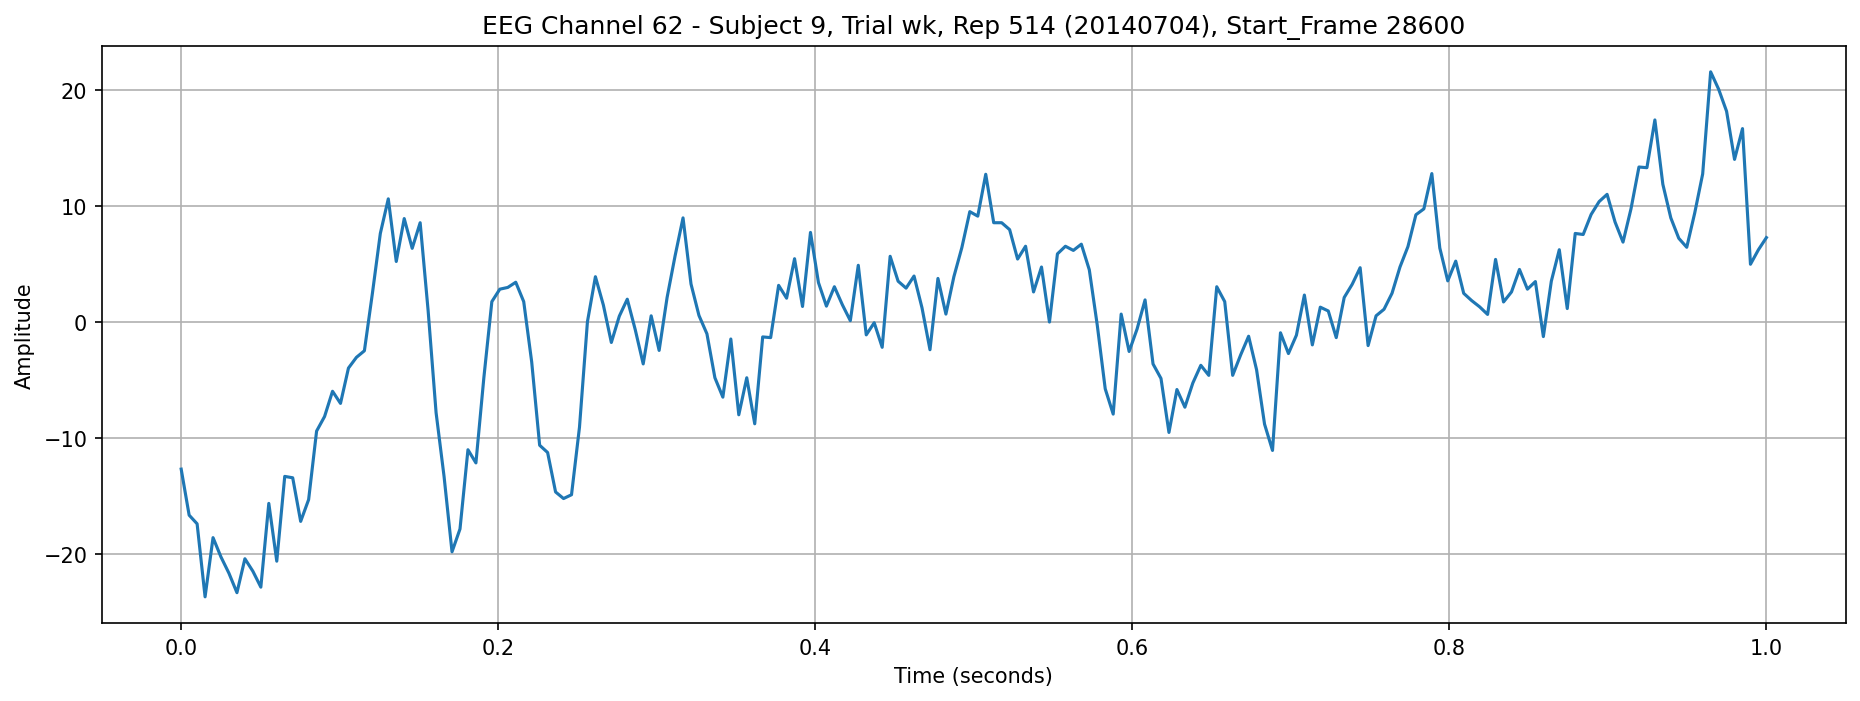

In [5]:
_loader.plot_random_eeg()

In [6]:
del _loader

### Data Augmentation

In [7]:
from dataset_processing.eeg_augmentation import EEGAugmentation

_augmentor = EEGAugmentation(_eeg_data_df)
_augmented_df = _augmentor.augment_data()
del _augmentor, _eeg_data_df

### Dataset Loader

In [8]:
from torch.utils.data import DataLoader
from dataset_processing.eeg_dataset import EEGDataset

# From the paper
pretraining_batch_size = 256

_dataset = EEGDataset(_augmented_df)
data_loader = DataLoader(_dataset, batch_size=pretraining_batch_size, shuffle=True)
del _augmented_df, _dataset

# Pre-Training

In [9]:
from model.encoders import TimeFrequencyEncoder, CrossSpaceProjector
from model.loss import NTXentLoss
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import os

model_save_dir = 'model_params'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [11]:
# Parameters from the paper
pretraining_epochs = 10  # Set to 10 for initial tests
# pretraining_epochs = 1000
pretraining_lr = 3e-4
l2_norm_penalty = 3e-4
alpha = 0.2
beta = 1.0
pretraining_temperature = 0.05

encoders_output_dim = 200
projectors_output_dim = 128

In [27]:
from importlib import reload
import model.loss
reload(model.loss)
NTXentLoss = model.loss.NTXentLoss

In [28]:
num_layers = 2
nhead = 8

# Initialize models
ET = TimeFrequencyEncoder(
    input_dim=sampling_frequency,
    output_dim=encoders_output_dim,
    num_layers=num_layers,
    nhead=nhead,
).to(device)
EF = TimeFrequencyEncoder(
    input_dim=sampling_frequency,
    output_dim=encoders_output_dim,
    num_layers=num_layers,
    nhead=nhead,
).to(device)
PT = CrossSpaceProjector(
    input_dim=encoders_output_dim,
    output_dim=projectors_output_dim,
).to(device)
PF = CrossSpaceProjector(
    input_dim=encoders_output_dim,
    output_dim=projectors_output_dim,
).to(device)

# Define optimizers with L2 penalty
optimizer = optim.Adam(
    list(ET.parameters()) + list(EF.parameters()) + list(PT.parameters()) + list(PF.parameters()),
    lr=pretraining_lr,
    weight_decay=l2_norm_penalty  # L2-norm penalty coefficient
)

nt_xent_calculator = NTXentLoss(temperature=pretraining_temperature)

# Pre-training loop
for epoch in range(1, pretraining_epochs + 1):
    for xT, xT_augmented, xF, xF_augmented in data_loader:
        # Move batches of data to the `device`
        xT = xT.to(device)
        xT_augmented = xT_augmented.to(device)
        xF = xF.to(device)
        xF_augmented = xF_augmented.to(device)

        # Reset the optimizers
        optimizer.zero_grad()

        # Time Domain Contrastive Learning
        hT = ET(xT)  # Encode time data
        hT_augmented = ET(xT_augmented)  # Encode augmented time data
        LT = nt_xent_calculator.calculate_loss(  # Calculate the time-based contrastive loss LT in Eq. 1
            hT,
            hT_augmented
        )

        # Frequency Domain Contrastive Learning
        hF = EF(xF)  # Encode frequency data
        hF_augmented = EF(xF_augmented)  # Encode augmented frequency data
        LF = nt_xent_calculator.calculate_loss(  # Calculate the frequency-based contrastive loss LF in Eq. 2
            hF,
            hF_augmented
        )

        # Time-Frequency Domain Contrastive Learning
        zT = PT(hT)  # Project into shared latent space
        zF = PF(hF)  # Project into shared latent space
        LA = nt_xent_calculator.calculate_loss(  # Calculate the alignment loss LA in Eq. 3
            zT,
            zF
        )

        # Compute total loss
        L = alpha * (LT + LF) + beta * LA

        # Backpropagation
        L.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Loss: {L.item()}")

    # Save the model every 10 epochs and at the last epoch
    if epoch % 10 == 0 or epoch == pretraining_epochs:
        model_dicts = {
            "ET_state_dict": ET.state_dict(),
            "EF_state_dict": EF.state_dict(),
            "PT_state_dict": PT.state_dict(),
            "PF_state_dict": PF.state_dict(),
        }
        torch.save(model_dicts, os.path.join(model_save_dir, f"pretrained_model__epoch_{epoch}.pth"))
        print(f"Saved model at epoch {epoch}")

Epoch 1, Loss: 22.474117279052734
Epoch 1, Loss: 19.350536346435547
Epoch 1, Loss: 18.359390258789062
Epoch 1, Loss: 17.808916091918945
Epoch 1, Loss: 18.20665168762207
Epoch 1, Loss: 18.035118103027344
Epoch 1, Loss: 17.53067398071289


KeyboardInterrupt: 

Do a correlation matrix between the channels of the EEG signals.
Then when doing the joint whatever model, use the "distances" between the channels (like the hamming distance but not really), as a "weight" for training the joining etc.